In [ ]:
import random
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt

from models.UNet import UNet
from dataset import ColorFaceDataset, ColorFaceTransform

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
VERSION = 1

In [4]:
def get_model():
    model = UNet(3, 3, 3).to(DEVICE)
    model.inc.double_conv[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.outc = torch.nn.Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
    return model

In [5]:
state_path = f"outputs/checkpoints/v{VERSION}/faceNet_best.pth"
model = get_model().to(DEVICE)
state = torch.load(str(state_path), map_location=DEVICE)
model.load_state_dict(state)
model.eval()
print("done")

done


In [6]:
valid_transform = ColorFaceTransform(is_train=False)
valid_dataset = ColorFaceDataset("data/valid.csv", valid_transform)

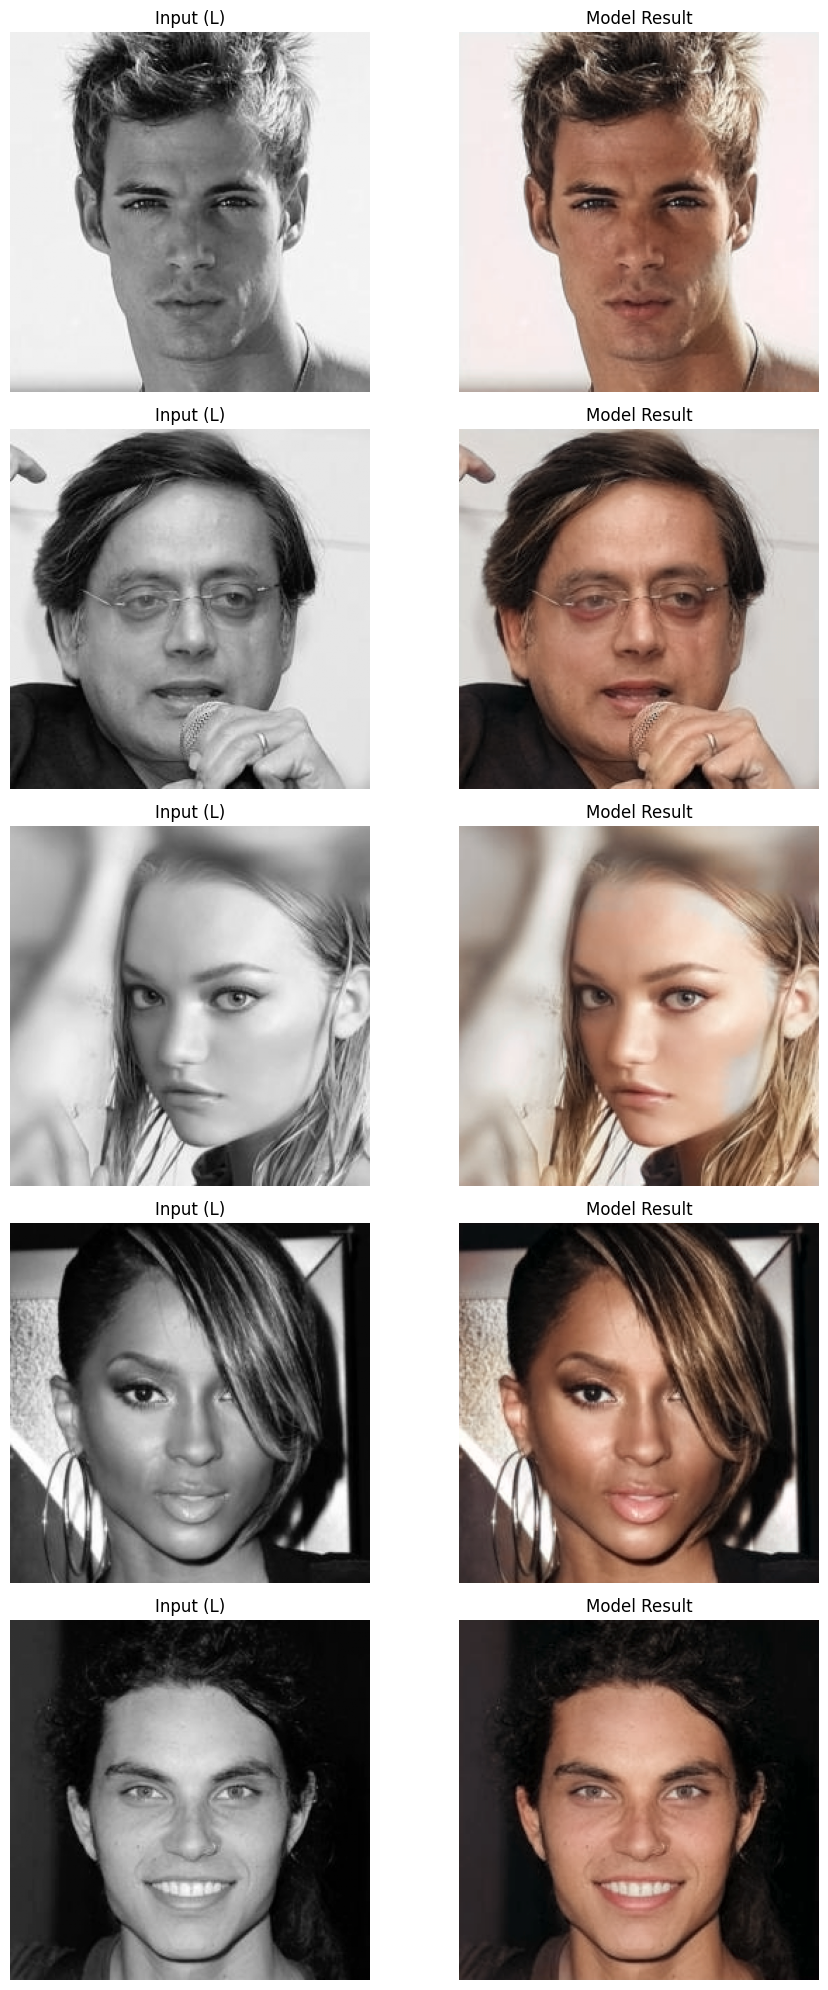

In [ ]:
num_samples = 5
random_indices = random.sample(range(len(valid_dataset)), num_samples)

# Get samples from the dataset
samples = [valid_dataset[i] for i in random_indices]

# Separate L and ab
L_images = torch.stack([s['L'] for s in samples]).to(DEVICE)       # [B,1,H,W]
ab_targets = torch.stack([s['ab'] for s in samples]).to(DEVICE)    # [B,2,H,W]

# Get model output
model.eval()
with torch.no_grad():
    ab_outputs = model(L_images)   # [B,2,H,W]


def lab_to_rgb(L_tensor, ab_tensor):
    # L_tensor: [1,H,W] or [H,W] (0..1)
    # ab_tensor: [2,H,W] (in [-1,1])
    # return: RGB HxWx3

    if L_tensor.ndim == 3:  # [1,H,W]
        L = L_tensor.squeeze(0).cpu().numpy()
    else:
        L = L_tensor.cpu().numpy()

    ab = ab_tensor.cpu().numpy().transpose(1,2,0)  # H,W,2

    L_cv = (L * 255.0).clip(0,255).astype(np.uint8)               # [0..255]
    ab_cv = (ab * 128.0 + 128.0).clip(0,255).astype(np.uint8)     # [0..255], center 128

    lab_cv = np.zeros((L_cv.shape[0], L_cv.shape[1], 3), dtype=np.uint8)
    lab_cv[..., 0] = L_cv
    lab_cv[..., 1] = ab_cv[..., 0]
    lab_cv[..., 2] = ab_cv[..., 1]

    rgb = cv2.cvtColor(lab_cv, cv2.COLOR_LAB2RGB)  
    return rgb


fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples*4))

for i in range(num_samples):
    L_img = L_images[i].cpu().squeeze(0).numpy()
    axes[i, 0].imshow(L_img, cmap='gray')
    axes[i, 0].set_title("Input (L)")
    axes[i, 0].axis('off')

    output_rgb = lab_to_rgb(L_images[i], ab_outputs[i])
    axes[i, 1].imshow(output_rgb)
    axes[i, 1].set_title("Model Result")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def test_model2(image_path, model, device, save=False, save_path="result.png"):
    model.eval()

    # --- Load image ---
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # --- RGB -> LAB ---
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB).astype(np.float32)

    # --- Extract L and normalize EXACTLY like dataset ---
    L = lab[..., 0] / 255.0                     # [H,W] in [0,1]
    L_tensor = torch.from_numpy(L) \
                    .unsqueeze(0) \
                    .unsqueeze(0) \
                    .to(device)                 # [1,1,H,W]

    # --- Model inference ---
    with torch.no_grad():
        ab_output = model(L_tensor)              # [1,2,H,W]

    # --- Convert to RGB using SAME function as validation ---
    output_rgb = lab_to_rgb(L_tensor[0], ab_output[0])

    # --- Save ---
    if save:
        plt.imsave(save_path, output_rgb)
        print(f"Saved to: {save_path}")

    # --- Show ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(L, cmap='gray')
    axes[0].set_title("Input L")
    axes[0].axis("off")

    axes[1].imshow(output_rgb)
    axes[1].set_title("Model Output")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()



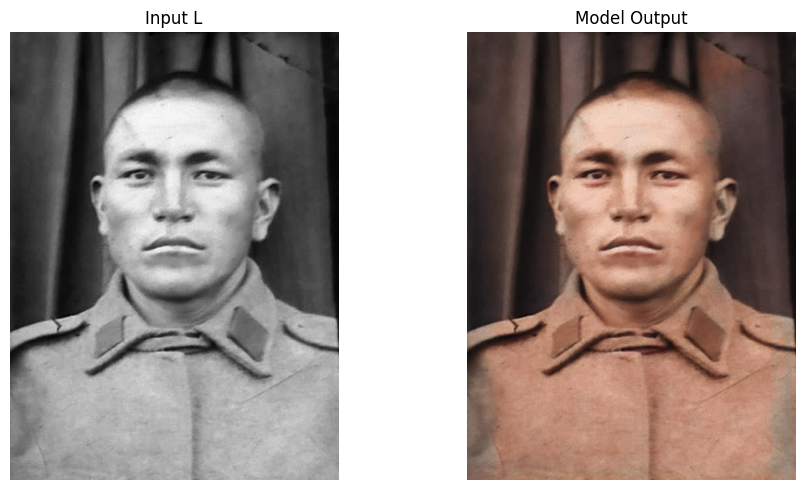

In [21]:
test_model2(
    # "files/original/ryan.jpg",
    "/home/phoenix/Desktop/test.jpeg",
    model,
    DEVICE,
)
